In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
import seaborn as sns
import torch
import time
import math
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_blobs
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss
from tqdm.notebook import tqdm
from IPython.display import HTML
from sklearn.preprocessing import OneHotEncoder

In [2]:
torch.manual_seed(0)

In [3]:
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('',["red","yellow","green"])

# **Generating Data**

In [4]:
data, labels = make_blobs(n_samples = 1000, centers = 4, n_features = 2, random_state = 0)

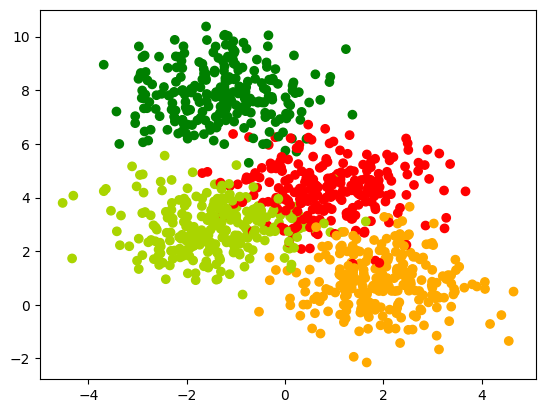

In [5]:
plt.scatter(data[:,0],data[:,1],c = labels, cmap = cmap)
plt.show()

In [6]:
X_train, X_test, Y_train, Y_test = train_test_split(data, labels, stratify = labels, random_state = 0)
print(X_train.shape, X_test.shape, Y_train.shape, Y_test.shape)

(750, 2) (250, 2) (750,) (250,)


# **Using torch Tensors and Autograd**

In [32]:
X_train, X_test, Y_train, Y_test = map(torch.tensor, (X_train, X_test, Y_train, Y_test))

C:\Users\Admin\AppData\Local\Temp\ipykernel_6976\2526291642.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train, X_test, Y_train, Y_test = map(torch.tensor, (X_train, X_test, Y_train, Y_test))


In [33]:
print(X_train.shape)

torch.Size([750, 2])


In [34]:
a = torch.rand(2,4)
print(a)
print(a.exp())
print(a.exp().sum())
print(a.exp().sum(0))
print(a.exp().sum(-1), a.exp().sum(-1).shape)
print(a.exp().sum(-1).unsqueeze(-1),a.exp().sum(-1).unsqueeze(-1).shape)

tensor([[0.4194, 0.5529, 0.9527, 0.0362],
        [0.1852, 0.3734, 0.3051, 0.9320]])
tensor([[1.5211, 1.7383, 2.5928, 1.0368],
        [1.2035, 1.4527, 1.3568, 2.5396]])
tensor(13.4415)
tensor([2.7246, 3.1910, 3.9496, 3.5764])
tensor([6.8890, 6.5525]) torch.Size([2])
tensor([[6.8890],
        [6.5525]]) torch.Size([2, 1])


In [35]:
def model(x):
    a1 = torch.matmul(x, weights1) + bias1           # (N,2) * (2,2) -> (N,2)
    h1 = a1.sigmoid()                                 # (N,2) -> (N,2)
    a2 = torch.matmul(h1, weights2) + bias2          # (N,2) * (2,4) -> (N, 4)
    h2 = a2.exp()/ a2.exp().sum(-1).unsqueeze(-1)    # (N,4) -> (N,4)
    return h2

In [36]:
def loss_fn(y_hat, y):
    return -(y_hat[range(y.shape[0]), y].log()).mean()

In [37]:
def accuracy(y_hat, y):
    pred = torch.argmax(y_hat, dim = 1)
    return (pred == y).float().mean()

  0%|          | 0/10000 [00:00<?, ?Epochs/s]

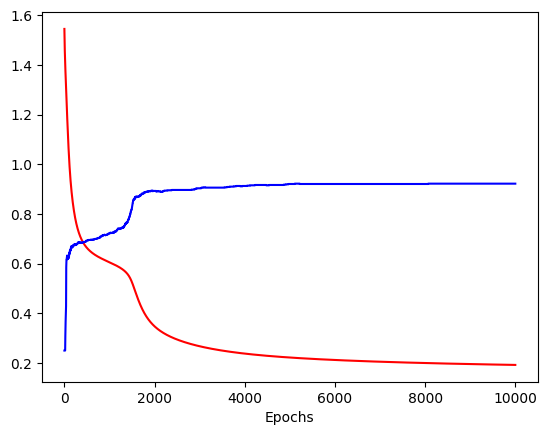

loss before training 1.5456440448760986
loss after training 0.19288595020771027


In [40]:
torch.manual_seed(0)
weights1 = torch.randn(2,2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad = True)
weights2 = torch.randn(2,4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad = True)
lr = 0.2
epochs = 10000
X_train = X_train.float()
Y_train = Y_train.long()
loss_arr = []
acc_arr = []
for epochs in tqdm(range(epochs), total = epochs, unit = "Epochs"):
    y_hat = model(X_train)
    loss = loss_fn(y_hat, Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))
    with torch.no_grad():
        weights1 -= lr * weights1.grad
        weights2 -= lr * weights2.grad
        bias1 -= lr * bias1.grad
        bias2 -= lr * bias2.grad
        weights1.grad.zero_()
        weights2.grad.zero_()
        bias1.grad.zero_()
        bias2.grad.zero_()
plt.plot(loss_arr,'r-')
plt.xlabel("Epochs")
plt.plot(acc_arr,'b-')
plt.show()
print("loss before training", loss_arr[0])
print("loss after training", loss_arr[-1])

# **NN Functional**

In [43]:
import torch.nn.functional as F

  0%|          | 0/10000 [00:00<?, ?Epochs/s]

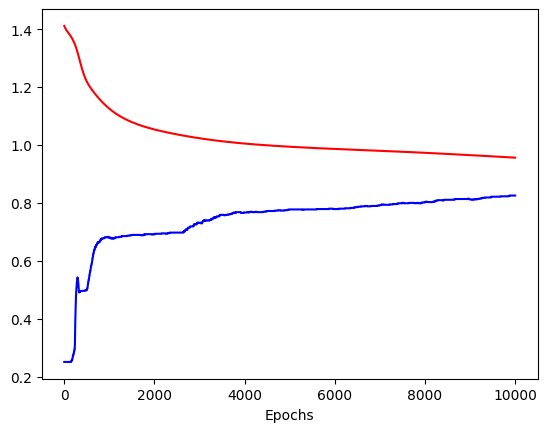

loss before training 1.4111982583999634
loss after training 0.9561847448348999


In [44]:
torch.manual_seed(0)
weights1 = torch.randn(2,2) / math.sqrt(2)
weights1.requires_grad_()
bias1 = torch.zeros(2, requires_grad = True)
weights2 = torch.randn(2,4) / math.sqrt(2)
weights2.requires_grad_()
bias2 = torch.zeros(4, requires_grad = True)
lr = 0.2
epochs = 10000
X_train = X_train.float()
Y_train = Y_train.long()
loss_arr = []
acc_arr = []
for epochs in tqdm(range(epochs), total = epochs, unit = "Epochs"):
    y_hat = model(X_train)
    loss = F.cross_entropy(y_hat, Y_train)
    loss.backward()
    loss_arr.append(loss.item())
    acc_arr.append(accuracy(y_hat, Y_train))
    with torch.no_grad():
        weights1 -= lr * weights1.grad
        weights2 -= lr * weights2.grad
        bias1 -= lr * bias1.grad
        bias2 -= lr * bias2.grad
        weights1.grad.zero_()
        weights2.grad.zero_()
        bias1.grad.zero_()
        bias2.grad.zero_()
plt.plot(loss_arr,'r-')
plt.xlabel("Epochs")
plt.plot(acc_arr,'b-')
plt.show()
print("loss before training", loss_arr[0])
print("loss after training", loss_arr[-1])

#  **NN.Parameter** 

In [45]:
import torch.nn as nn

In [60]:
class FirstNNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.weights1 = nn.Parameter(torch.randn(2,2) / math.sqrt(2))
        self.weights2 = nn.Parameter(torch.randn(2,4) / math.sqrt(2))
        self.bias1 = nn.Parameter(torch.zeros(2))
        self.bias2 = nn.Parameter(torch.zeros(4))
    def forward(self, X):
        a1 = torch.matmul(X, self.weights1) + self.bias1
        h1 = a1.sigmoid()
        a2 = torch.matmul(h1, self.weights2) + self.bias2 
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

In [63]:
def fit(epochs = 1000, lr = 1):
    loss_arr = []
    acc_arr = []
    for epochs in tqdm(range(epochs), total = epochs, unit = "epoch"):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss.backward()
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))
        with torch.no_grad():
            for param in fn.parameters():
                if param.grad is not None:
                    param -= lr * param.grad
            fn.zero_grad()
    plt.plot(loss_arr,'r-')
    plt.xlabel("Epochs")
    plt.plot(acc_arr,'b-')
    plt.show()
    print("Loss before training", loss_arr[0])
    print("Loss after training", loss_arr[-1])

  0%|          | 0/1000 [00:00<?, ?epoch/s]

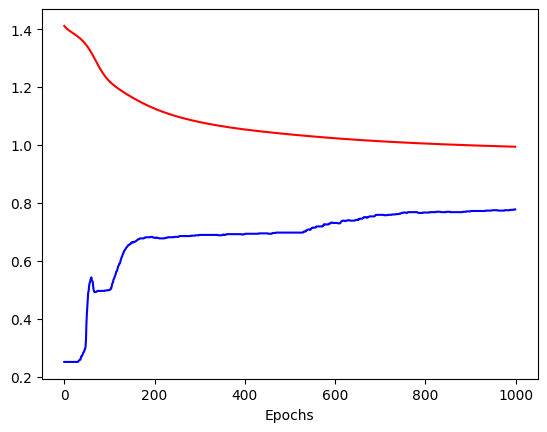

Loss before training 1.4111982583999634
Loss after training 0.9939236044883728


In [64]:
fn = FirstNNetwork()
fit()

# **NN.Linear and Optim**

In [67]:
class FirstNNetwork_v1(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.lin1 = nn.Linear(2,2)
        self.lin2 = nn.Linear(2,4)
    def forward(self, X):
        a1 = self.lin1(X)
        h1 = a1.sigmoid()
        a2 = self.lin2(h1)
        h2 = a2.exp()/a2.exp().sum(-1).unsqueeze(-1)
        return h2

  0%|          | 0/1000 [00:00<?, ?epoch/s]

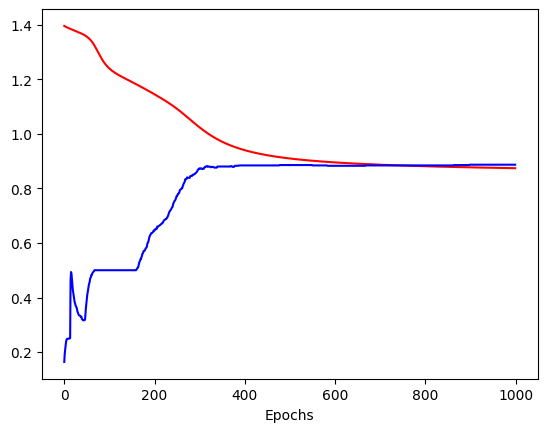

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [68]:
fn = FirstNNetwork_v1()
fit()

In [69]:
from torch import optim

In [72]:
def fit_v1(epochs = 1000, lr = 1):
    loss_arr = []
    acc_arr = []
    opt = optim.SGD(fn.parameters(), lr = lr)
    for epochs in tqdm(range(epochs), total = epochs, unit = "epochs"):
        y_hat = fn(X_train)
        loss = F.cross_entropy(y_hat, Y_train)
        loss.backward()
        loss_arr.append(loss.item())
        acc_arr.append(accuracy(y_hat, Y_train))
        opt.step()
        opt.zero_grad()
    plt.plot(loss_arr, 'r-')
    plt.plot(acc_arr, 'b-')
    plt.show()
    print("Loss before training", loss_arr[0])
    print("Loss after training", loss_arr[-1])

  0%|          | 0/1000 [00:00<?, ?epochs/s]

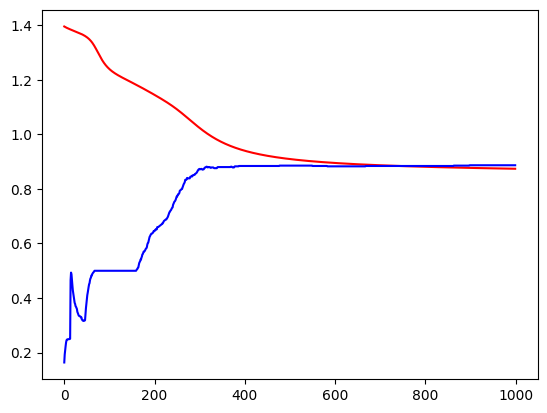

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [73]:
fn = FirstNNetwork_v1()
fit_v1()

# **NN.Sequential**

In [76]:
class FirstNNetwork_v2(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2,2),
            nn.Sigmoid(),
            nn.Linear(2,4),
            nn.Softmax(dim = 1)
        )
    def forward(self, X):
        return self.net(X)

  0%|          | 0/1000 [00:00<?, ?epochs/s]

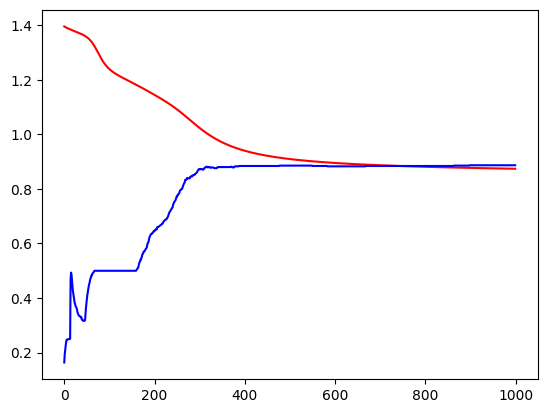

Loss before training 1.3951597213745117
Loss after training 0.8738412857055664


In [77]:
fn = FirstNNetwork_v2()
fit_v1()

In [81]:
def fit_v2(X, Y, model, loss_fn, opt, epochs = 1000):
    for epochs in tqdm(range(epochs), total = epochs, unit = "epoch"):
        loss = loss_fn(model(X), Y)
        loss.backward()
        opt.step()
        opt.zero_grad()
    return loss.item()

In [83]:
fn = FirstNNetwork_v2()
loss_fn = F.cross_entropy
opt = optim.SGD(fn.parameters(), lr = 1)
fit_v2(X_train, Y_train, fn, loss_fn, opt)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

0.8738412857055664

# **Moving to CUDA**

In [92]:
class FirstNNetwork_v3(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(0)
        self.net = nn.Sequential(
            nn.Linear(2,1024),
            nn.Sigmoid(),
            nn.Linear(1024,4),
            nn.Softmax(dim = 1)
        )
    def forward(self, X):
        return self.net(X)

In [93]:
device = torch.device("cpu")
X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNNetwork_v3()
fn.to(device)
tic = time.time()
finalloss = fit_v2(X_train, Y_train, fn, loss_fn, opt)
print("Final loss : ", finalloss)
tac = time.time()
print("Time taken : ", tac-tic)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Final loss :  1.3988271951675415
Time taken :  21.35188102722168


In [94]:
device = torch.device("cuda")
X_train = X_train.to(device)
Y_train = Y_train.to(device)
fn = FirstNNetwork_v2()
fn.to(device)
tic = time.time()
finalloss = fit_v2(X_train, Y_train, fn, loss_fn, opt)
print("Final loss : ", finalloss)
tac = time.time()
print("Time taken : ", tac-tic)

  0%|          | 0/1000 [00:00<?, ?epoch/s]

Final loss :  1.3951594829559326
Time taken :  2.066563844680786
